# Load merchant embeddings and transactions embeddings and see if we have any matches

In [1]:
%pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 45.0 MB/s eta 0:00:0000:01
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
!ls /opt/conda/lib/python3.10/site-packages/fsspec*

/opt/conda/lib/python3.10/site-packages/fsspec:
__init__.py  caching.py      core.py	    gui.py	     spec.py
__pycache__  callbacks.py    dircache.py    implementations  tests
_version.py  compression.py  exceptions.py  mapping.py	     transaction.py
archive.py   config.py	     fuse.py	    parquet.py	     utils.py
asyn.py      conftest.py     generic.py     registry.py

/opt/conda/lib/python3.10/site-packages/fsspec-2023.6.0.dist-info:
INSTALLER  METADATA  REQUESTED	direct_url.json
LICENSE    RECORD    WHEEL	top_level.txt


In [3]:
%pip install faiss-cpu

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install fsspec==2023.6.0

Note: you may need to restart the kernel to use updated packages.


In [5]:
!ls /opt/conda/lib/python3.10/site-packages/fsspec*

/opt/conda/lib/python3.10/site-packages/fsspec:
__init__.py  caching.py      core.py	    gui.py	     spec.py
__pycache__  callbacks.py    dircache.py    implementations  tests
_version.py  compression.py  exceptions.py  mapping.py	     transaction.py
archive.py   config.py	     fuse.py	    parquet.py	     utils.py
asyn.py      conftest.py     generic.py     registry.py

/opt/conda/lib/python3.10/site-packages/fsspec-2023.6.0.dist-info:
INSTALLER  METADATA  REQUESTED	direct_url.json
LICENSE    RECORD    WHEEL	top_level.txt


In [6]:
#!mv /opt/conda/lib/python3.10/site-packages/fsspec-2023.6.0.dist-info/ mm/


In [7]:
!ls /opt/conda/lib/python3.10/site-packages/fsspec-2023.6.0.dist-info/

INSTALLER  METADATA  REQUESTED	direct_url.json
LICENSE    RECORD    WHEEL	top_level.txt


In [8]:
%pip install accelerate==0.27.2
%pip install sentence-transformers
%pip install --upgrade sentence_transformers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
#%pip install --force-reinstall --no-deps fsspec==2023.6.0


### Download model

In [10]:
import boto3
import os

def download_s3_folder(bucket_name, s3_folder, local_path):
    """
    Download a folder (or "prefix") from S3 to the local filesystem.
    """
    s3 = boto3.client('s3')
    paginator = s3.get_paginator('list_objects_v2')
    for result in paginator.paginate(Bucket=bucket_name, Prefix=s3_folder):
        if 'Contents' in result:
            for key in result['Contents']:
                # Extract file name from S3 key
                key_name = key['Key']
                local_file_path = os.path.join(local_path, os.path.basename(key_name))
                
                # Check if the key represents a folder
                if key_name.endswith('/'):
                    # Create local directory if it doesn't exist
                    os.makedirs(local_file_path, exist_ok=True)
                    # Recursively download folder contents
                    download_s3_folder(bucket_name, key_name, local_file_path)
                else:
                    # Create directory if it doesn't exist
                    os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
                    # Download file
                    try:
                        s3.download_file(bucket_name, key_name, local_file_path)
                    except NotADirectoryError as e:
                        print(f"Skipping file '{key_name}' due to error: {e}")

# Example usage
bucket_name = 'cleo-data-science'
base_name_path = 'model9/checkpoint-2000'
s3_folder = f"transaction_enrichment/experimental_data/caste/pairs_model/{base_name_path}"
local_path = f"/home/sagemaker-user/models/{base_name_path}"

download_s3_folder(bucket_name, s3_folder, local_path)

bucket_name = 'cleo-data-science'
s3_folder = f"transaction_enrichment/experimental_data/caste/pairs_model/{base_name_path}/1_Pooling"
local_path = f"/home/sagemaker-user/models/{base_name_path}/1_Pooling"


download_s3_folder(bucket_name, s3_folder, local_path)


In [11]:
!ls /home/sagemaker-user/models/

model9


In [12]:
imodel = 9

### Load test data

In [13]:
%pip install awswrangler
import awswrangler as wr

Note: you may need to restart the kernel to use updated packages.


In [14]:

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

### Load embeddings

In [15]:
# s3_path_tx_embeddings = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/with_merchant_embeddings_trans_2024-05-22_2024-05-22.parquet"
# s3_path_tx_descriptions = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/with_merchant_trans_2024-05-22_2024-05-22.parquet"
# # --- no merchant
# s3_path_tx_embeddings ="s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/no_merchant_embeddings_trans_2024-05-22_2024-05-22.parquet"
# s3_path_tx_descriptions = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/no_merchant_trans_2024-05-22_2024-05-22.parquet"
# # --- with duplicates
# s3_path_tx_descriptions = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/with_duplicate_merchant_trans_2024-05-22_2024-05-22.parquet"
# s3_path_tx_embeddings ="s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/with_duplicate_merchant_embeddings_trans_2024-05-22_2024-05-22.parquet"
# s3_path_duplicate_mapping = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/map_duplicates_cons_2024-05-15_2024-05-18_1.csv"

In [16]:
s3_path_merchant_embeddings = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/merchant_embeddings_cons_2024-05-15_2024-05-18_1.parquet"
s3_path_merchant_embeddings = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-7800/merchant_embeddings_cons_2024-05-15_2024-05-18_1.parquet"
s3_path_duplicate_merchant_embeddings = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-7800/duplicate_merchant_embeddings_cons_2024-05-15_2024-05-18_1.parquet"

In [17]:
df_merchant_embeddings = wr.s3.read_parquet(path=s3_path_merchant_embeddings)

In [18]:
df_duplicate_merchant_embeddings = wr.s3.read_parquet(path=s3_path_duplicate_merchant_embeddings)


In [19]:
df_duplicate_merchant_embeddings

,true_merchant_name_combined,cnt_original_merchants,original_merchant_name_combined_list,original_merchant_name_combined_list_cln,true_merchant_name_combined_embedding
0,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[1.3889267444610596, 0.32924503087997437, 0.42..."
1,Bank of America,23,"[Bank of America ATM, Overdraft Charge, Four P...","[Bank of America ATM, Four Points, Bank Of Ame...","[0.07139328867197037, 0.43167418241500854, -0...."
2,California DMV,22,"[Ca Dmv 516, State Of Calif Dmv Int, Ca Dmv Oa...","[Ca Dmv 516, State Of Calif Dmv Int, Ca Dmv Oa...","[0.3886001408100128, 0.066037617623806, -0.097..."
3,Citizens Bank,19,"[Citizens Bank Payroll, First Citizens, Citize...","[Citizens Bank Payroll, First Citizens, Citize...","[-0.6828196048736572, -0.09508171677589417, -0..."
4,WESCO International,18,"[Wesco 7 Grand Haven, Wesco 2, Wesco 45, Wesco...","[Wesco 7 Grand Haven, Wesco 2, Wesco 45, Wesco...","[0.24168661236763, -0.318260133266449, 0.68920..."
...,...,...,...,...,...
7326,Fry''s Food and Drug,1,[Fry''s Food & Drug],[Fry''s Food & Drug],"[0.5837705731391907, 0.7663185000419617, -0.04..."
7327,Frwy Usag,1,[Frwy Usag Ins],[Frwy Usag Ins],"[-0.3360418379306793, 0.22922158241271973, 0.7..."
7328,Frwy Baja,1,[Frwy Baja Ins],[Frwy Baja Ins],"[0.11730863898992538, 0.19552990794181824, 1.6..."
7329,Frutas Y Antojitos Ros,1,[Frutas Y Antojitos Rosi],[Frutas Y Antojitos Rosi],"[-0.22422045469284058, 0.16477155685424805, 0...."


In [20]:
from sentence_transformers import SentenceTransformer, models
# from sentence_transformers import SentenceTransformer, InputExample
# from torch.utils.data import DataLoader
# from torch.utils.data import Dataset, DataLoader
# from sentence_transformers.losses import CoSENTLoss
# from datasets import Dataset
# from sentence_transformers.training_args import SentenceTransformerTrainingArguments
# from sentence_transformers.training_args import BatchSamplers
# from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
# from sentence_transformers import SentenceTransformerTrainer

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-06-21 01:39:27.615338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
df_merchant_embeddings.head()

,original_merchant_name_combined,count,original_merchant_name_combined_embedding
0,Cash App,235691,"[-1.50139319896698, 0.150117427110672, -0.1454..."
1,Savings,200907,"[-0.09797230362892151, 0.4686727821826935, -0...."
2,Dave Inc,156513,"[-0.7331416010856628, 0.7645961046218872, -0.0..."
3,Walmart,135952,"[0.8744958639144897, -0.9964747428894043, 0.67..."
4,Cash Withdrawal,133395,"[-0.8114951848983765, -0.18434709310531616, 0...."


In [22]:
embeddings_merchants = df_merchant_embeddings['original_merchant_name_combined_embedding'].tolist()

In [23]:
embedding_duplicate_merchants = df_duplicate_merchant_embeddings['true_merchant_name_combined_embedding'].tolist()

In [24]:
df_duplicate_merchant_embeddings['cnt_orignial_merchants_cln'] = df_duplicate_merchant_embeddings['original_merchant_name_combined_list_cln'].apply(lambda x: len(x))
df_duplicate_merchant_embeddings[0:10]

,true_merchant_name_combined,cnt_original_merchants,original_merchant_name_combined_list,original_merchant_name_combined_list_cln,true_merchant_name_combined_embedding,cnt_orignial_merchants_cln
0,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[1.3889267444610596, 0.32924503087997437, 0.42...",80
1,Bank of America,23,"[Bank of America ATM, Overdraft Charge, Four P...","[Bank of America ATM, Four Points, Bank Of Ame...","[0.07139328867197037, 0.43167418241500854, -0....",18
2,California DMV,22,"[Ca Dmv 516, State Of Calif Dmv Int, Ca Dmv Oa...","[Ca Dmv 516, State Of Calif Dmv Int, Ca Dmv Oa...","[0.3886001408100128, 0.066037617623806, -0.097...",22
3,Citizens Bank,19,"[Citizens Bank Payroll, First Citizens, Citize...","[Citizens Bank Payroll, First Citizens, Citize...","[-0.6828196048736572, -0.09508171677589417, -0...",15
4,WESCO International,18,"[Wesco 7 Grand Haven, Wesco 2, Wesco 45, Wesco...","[Wesco 7 Grand Haven, Wesco 2, Wesco 45, Wesco...","[0.24168661236763, -0.318260133266449, 0.68920...",17
5,Ally Bank,16,"[Savings, Ally Ally Paymt, Ally Lending Online...","[Ally Ally Paymt, Ally Lending Onlinepymt, All...","[-0.5126493573188782, -0.3540343940258026, 0.1...",12
6,Loaf ''N Jug,15,"[Loaf N Ju 3980 Ivywood Pueblo, Loaf N Ju 5539...","[Loaf N Ju 3980 Ivywood Pueblo, Loaf N Ju 5539...","[0.6726908087730408, 0.7471350431442261, -0.06...",14
7,Oportun Financial,14,"[Oportun Rainy Day, Oportun/Progress, Oportun ...","[Oportun Rainy Day, Oportun/Progress, Oportun ...","[-0.9165062308311462, -0.5184594988822937, -0....",12
8,Rainbow Shops,14,"[Rainbow 155 Whit Bronx, Rainbow Morrow, Rainb...","[Rainbow 155 Whit Bronx, Rainbow Morrow, Rainb...","[0.08037272840738297, -0.12219145894050598, -0...",14
9,Navy Federal Credit Union,11,"[Nfcu Ach Payment, Spdpy* Nfcu, Navy Federal U...","[Nfcu Ach Payment, Spdpy* Nfcu, Navy Federal U...","[0.6616209149360657, 0.03216806426644325, -0.5...",9


In [25]:
path_mapping_duplicates = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-7800/duplicate_merchant_mapping_cln_cons_2024-05-15_2024-05-18_1.csv"
wr.s3.to_csv(df_duplicate_merchant_embeddings.drop('true_merchant_name_combined_embedding', axis=1),path_mapping_duplicates)

{'paths': ['s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-7800/duplicate_merchant_mapping_cln_cons_2024-05-15_2024-05-18_1.csv'],
 'partitions_values': {}}

In [26]:
df_duplicate_merchant_embeddings[0:10]

,true_merchant_name_combined,cnt_original_merchants,original_merchant_name_combined_list,original_merchant_name_combined_list_cln,true_merchant_name_combined_embedding,cnt_orignial_merchants_cln
0,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[1.3889267444610596, 0.32924503087997437, 0.42...",80
1,Bank of America,23,"[Bank of America ATM, Overdraft Charge, Four P...","[Bank of America ATM, Four Points, Bank Of Ame...","[0.07139328867197037, 0.43167418241500854, -0....",18
2,California DMV,22,"[Ca Dmv 516, State Of Calif Dmv Int, Ca Dmv Oa...","[Ca Dmv 516, State Of Calif Dmv Int, Ca Dmv Oa...","[0.3886001408100128, 0.066037617623806, -0.097...",22
3,Citizens Bank,19,"[Citizens Bank Payroll, First Citizens, Citize...","[Citizens Bank Payroll, First Citizens, Citize...","[-0.6828196048736572, -0.09508171677589417, -0...",15
4,WESCO International,18,"[Wesco 7 Grand Haven, Wesco 2, Wesco 45, Wesco...","[Wesco 7 Grand Haven, Wesco 2, Wesco 45, Wesco...","[0.24168661236763, -0.318260133266449, 0.68920...",17
5,Ally Bank,16,"[Savings, Ally Ally Paymt, Ally Lending Online...","[Ally Ally Paymt, Ally Lending Onlinepymt, All...","[-0.5126493573188782, -0.3540343940258026, 0.1...",12
6,Loaf ''N Jug,15,"[Loaf N Ju 3980 Ivywood Pueblo, Loaf N Ju 5539...","[Loaf N Ju 3980 Ivywood Pueblo, Loaf N Ju 5539...","[0.6726908087730408, 0.7471350431442261, -0.06...",14
7,Oportun Financial,14,"[Oportun Rainy Day, Oportun/Progress, Oportun ...","[Oportun Rainy Day, Oportun/Progress, Oportun ...","[-0.9165062308311462, -0.5184594988822937, -0....",12
8,Rainbow Shops,14,"[Rainbow 155 Whit Bronx, Rainbow Morrow, Rainb...","[Rainbow 155 Whit Bronx, Rainbow Morrow, Rainb...","[0.08037272840738297, -0.12219145894050598, -0...",14
9,Navy Federal Credit Union,11,"[Nfcu Ach Payment, Spdpy* Nfcu, Navy Federal U...","[Nfcu Ach Payment, Spdpy* Nfcu, Navy Federal U...","[0.6616209149360657, 0.03216806426644325, -0.5...",9


In [27]:
print(len(embeddings_merchants))

86094


In [28]:
print(len(embedding_duplicate_merchants))

7331


In [29]:
imodel = 9
istep = 7800
model_name = f"/home/sagemaker-user/models/model{imodel}/checkpoint-{istep}"
model = SentenceTransformer(model_name)

In [30]:
import torch

In [31]:
similarities = model.similarity(embedding_duplicate_merchants, embeddings_merchants)

/opt/conda/lib/python3.10/site-packages/sentence_transformers/util.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680572619157/work/torch/csrc/utils/tensor_new.cpp:245.)
  a = torch.tensor(a)


In [32]:
similarities.shape

torch.Size([7331, 86094])

In [33]:
len(similarities[0])

86094

In [34]:
debug = 0
ix = 9 
N = 50
min_sim_th = 0.2
results = []
N_values = np.array([])
avg_rcall_N = np.array([])
for N in np.arange(10, 200, 20):
    print(N)
    N_values = np.append(N_values, N)
    all_recall_N = np.array([])
    for ix in range(similarities.shape[0]):

        one_dup = np.array(similarities[ix])
        flat_indices = np.argpartition(one_dup, -N)[-N:]
        #print(flat_indices)
        # multi_dim_indices = np.unravel_index(flat_indices, one_dup.shape)
        # print(multi_dim_indices[0])
        largest_values = one_dup[flat_indices]

        flat_inices_pos_similarity = flat_indices[largest_values>min_sim_th]
        if debug: print(flat_inices_pos_similarity)
        #print(largest_values)
        largest_values_pos_similarity = one_dup[flat_inices_pos_similarity]
        if debug: print(largest_values_pos_similarity)
        results.append([ix, flat_inices_pos_similarity, largest_values_pos_similarity])
        # compute recall 
        candidate_matching_merchant_names = df_merchant_embeddings.loc[flat_inices_pos_similarity,'original_merchant_name_combined'].tolist()

        true_duplicate_names = df_duplicate_merchant_embeddings.loc[ix,'original_merchant_name_combined_list_cln'].tolist()

        duplicate_names_found = [x for x in true_duplicate_names if x in candidate_matching_merchant_names]
        recall = len(duplicate_names_found)/len(true_duplicate_names)
        all_recall_N = np.append(all_recall_N,recall)
        if debug: print(f"Recall {recall}")
    print(all_recall_N.mean())
    avg_rcall_N  = np.append(avg_rcall_N, all_recall_N.mean())


10


0.9004715574882954
30
0.9266831649885683
50
0.9341690253065797
70
0.9381619944390251
90
0.9420713822745486
110
0.9435837682501728
130
0.9448569006104692
150
0.9463654019785517
170
0.947320251248774
190
0.9480494605426403


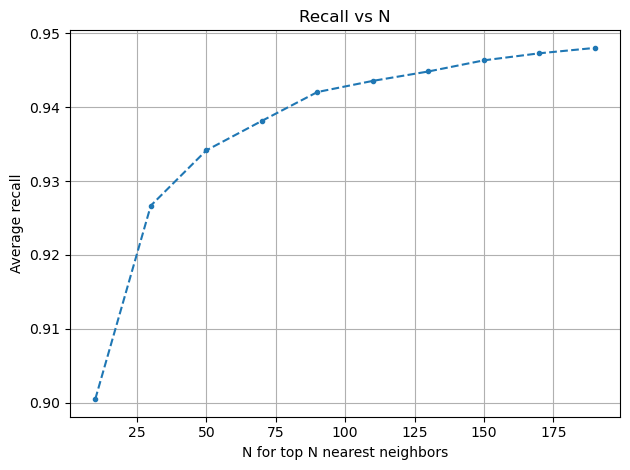

In [35]:
plt.plot(N_values, avg_rcall_N,'.--')
plt.xlabel('N for top N nearest neighbors')
plt.ylabel('Average recall')
plt.title('Recall vs N')
plt.grid('on')
plt.tight_layout()
plt.savefig('/home/sagemaker-user/FIGS/recall_vs_N.png')

In [36]:
df_duplicate_merchant_embeddings

,true_merchant_name_combined,cnt_original_merchants,original_merchant_name_combined_list,original_merchant_name_combined_list_cln,true_merchant_name_combined_embedding,cnt_orignial_merchants_cln
0,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[1.3889267444610596, 0.32924503087997437, 0.42...",80
1,Bank of America,23,"[Bank of America ATM, Overdraft Charge, Four P...","[Bank of America ATM, Four Points, Bank Of Ame...","[0.07139328867197037, 0.43167418241500854, -0....",18
2,California DMV,22,"[Ca Dmv 516, State Of Calif Dmv Int, Ca Dmv Oa...","[Ca Dmv 516, State Of Calif Dmv Int, Ca Dmv Oa...","[0.3886001408100128, 0.066037617623806, -0.097...",22
3,Citizens Bank,19,"[Citizens Bank Payroll, First Citizens, Citize...","[Citizens Bank Payroll, First Citizens, Citize...","[-0.6828196048736572, -0.09508171677589417, -0...",15
4,WESCO International,18,"[Wesco 7 Grand Haven, Wesco 2, Wesco 45, Wesco...","[Wesco 7 Grand Haven, Wesco 2, Wesco 45, Wesco...","[0.24168661236763, -0.318260133266449, 0.68920...",17
...,...,...,...,...,...,...
7326,Fry''s Food and Drug,1,[Fry''s Food & Drug],[Fry''s Food & Drug],"[0.5837705731391907, 0.7663185000419617, -0.04...",1
7327,Frwy Usag,1,[Frwy Usag Ins],[Frwy Usag Ins],"[-0.3360418379306793, 0.22922158241271973, 0.7...",1
7328,Frwy Baja,1,[Frwy Baja Ins],[Frwy Baja Ins],"[0.11730863898992538, 0.19552990794181824, 1.6...",1
7329,Frutas Y Antojitos Ros,1,[Frutas Y Antojitos Rosi],[Frutas Y Antojitos Rosi],"[-0.22422045469284058, 0.16477155685424805, 0....",1


### pick one value of N

In [37]:
debug = 0
ix = 9 
N = 50
min_sim_th = 0.2
results = []
N_values = np.array([])
avg_rcall_N = np.array([])
for N in np.arange(10, 11, 20):
    print(N)
    N_values = np.append(N_values, N)
    all_recall_N = np.array([])
    for ix in range(similarities.shape[0]):
        name_anchor_merchant = df_duplicate_merchant_embeddings.loc[ix,'true_merchant_name_combined']
        one_dup = np.array(similarities[ix])
        flat_indices = np.argpartition(one_dup, -N)[-N:]
        #print(flat_indices)
        # multi_dim_indices = np.unravel_index(flat_indices, one_dup.shape)
        # print(multi_dim_indices[0])
        largest_values = one_dup[flat_indices]

        flat_inices_pos_similarity = flat_indices[largest_values>min_sim_th]
        if debug: print(flat_inices_pos_similarity)
        #print(largest_values)
        largest_values_pos_similarity = one_dup[flat_inices_pos_similarity]
        if debug: print(largest_values_pos_similarity)
        matched_merchant_names = df_merchant_embeddings.loc[flat_inices_pos_similarity,'original_merchant_name_combined'].tolist()
        if debug : matched_merchant_names
        results.append([ix, name_anchor_merchant, flat_inices_pos_similarity, largest_values_pos_similarity, matched_merchant_names])
        # compute recall 
        candidate_matching_merchant_names = df_merchant_embeddings.loc[flat_inices_pos_similarity,'original_merchant_name_combined'].tolist()

        true_duplicate_names = df_duplicate_merchant_embeddings.loc[ix,'original_merchant_name_combined_list_cln'].tolist()

        duplicate_names_found = [x for x in true_duplicate_names if x in candidate_matching_merchant_names]
        recall = len(duplicate_names_found)/len(true_duplicate_names)
        all_recall_N = np.append(all_recall_N,recall)
        if debug: print(f"Recall {recall}")
    print(all_recall_N.mean())
    avg_rcall_N  = np.append(avg_rcall_N, all_recall_N.mean())


10


0.9004715574882954


In [38]:
df_nearest_neighbors = pd.DataFrame(results)
df_nearest_neighbors.columns = ['ix','anchor_name_merchant','ix_merchant','similarity_value','matched_merchant_names']
df_nearest_neighbors

,ix,anchor_name_merchant,ix_merchant,similarity_value,matched_merchant_names
0,0,76 Gas Stations,"[37201, 15689, 13498, 39593, 71458, 25420, 678...","[0.7841090433838298, 0.7919901118629062, 0.797...","[76 Bockman 76 San Lorenzo, 76 Airway Deli, 76..."
1,1,Bank of America,"[67673, 3735, 69375, 42221, 36419, 51, 1107, 3...","[0.5701036292261469, 0.5872116965749368, 0.607...","[America Financial, The Bancorp Bank, BankWest..."
2,2,California DMV,"[61029, 36944, 712, 36917, 31195, 49405, 36946...","[0.8032489004282568, 0.8038115589363584, 1.000...","[Ca Dmv 543, Ca Dmv 576, California DMV, Ca Dm..."
3,3,Citizens Bank,"[73108, 36782, 36890, 36780, 16448, 4202, 1655...","[0.7580571847014475, 0.7590678414331214, 0.787...","[Citizens Electric, Citizens One, Spdpy Citize..."
4,4,WESCO International,"[15607, 14238, 17151, 14735, 1061, 65947, 3693...","[0.9248049069396865, 0.929656812098999, 0.9454...","[Wesco 7, Wesco Gas, Wesco 45, Wesco 2, WESCO ..."
...,...,...,...,...,...
7326,7326,Fry''s Food and Drug,"[7932, 56487, 575, 42594, 4820, 7928, 1164, 14...","[0.7651391494149729, 0.7715938331052629, 0.791...","[Frys Del Via Instacart, Fryer's Chicken, Frys..."
7327,7327,Frwy Usag,"[26884, 81180, 50104, 801, 82806, 30353, 77441...","[0.568525337978593, 0.5706174271091821, 0.5722...","[Rev, Fnr Mo, Revc, Revvi, Froth, Fre, Frx Pro..."
7328,7328,Frwy Baja,"[56500, 65632, 34057, 801, 82806, 30353, 77441...","[0.5707548504474769, 0.5878349216333654, 0.578...","[Froz Shaved Ice, Freggy Hernandez, Frwy Oasis..."
7329,7329,Frutas Y Antojitos Ros,"[71477, 23926, 44819, 42764, 73215, 69921, 266...","[0.5717787130634173, 0.5720205754692598, 0.572...","[Fridas Mexican Gr, La Antojeria Jalisco, Frid..."


In [40]:
df_duplicate_merchant_embeddings

,true_merchant_name_combined,cnt_original_merchants,original_merchant_name_combined_list,original_merchant_name_combined_list_cln,true_merchant_name_combined_embedding,cnt_orignial_merchants_cln
0,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[1.3889267444610596, 0.32924503087997437, 0.42...",80
1,Bank of America,23,"[Bank of America ATM, Overdraft Charge, Four P...","[Bank of America ATM, Four Points, Bank Of Ame...","[0.07139328867197037, 0.43167418241500854, -0....",18
2,California DMV,22,"[Ca Dmv 516, State Of Calif Dmv Int, Ca Dmv Oa...","[Ca Dmv 516, State Of Calif Dmv Int, Ca Dmv Oa...","[0.3886001408100128, 0.066037617623806, -0.097...",22
3,Citizens Bank,19,"[Citizens Bank Payroll, First Citizens, Citize...","[Citizens Bank Payroll, First Citizens, Citize...","[-0.6828196048736572, -0.09508171677589417, -0...",15
4,WESCO International,18,"[Wesco 7 Grand Haven, Wesco 2, Wesco 45, Wesco...","[Wesco 7 Grand Haven, Wesco 2, Wesco 45, Wesco...","[0.24168661236763, -0.318260133266449, 0.68920...",17
...,...,...,...,...,...,...
7326,Fry''s Food and Drug,1,[Fry''s Food & Drug],[Fry''s Food & Drug],"[0.5837705731391907, 0.7663185000419617, -0.04...",1
7327,Frwy Usag,1,[Frwy Usag Ins],[Frwy Usag Ins],"[-0.3360418379306793, 0.22922158241271973, 0.7...",1
7328,Frwy Baja,1,[Frwy Baja Ins],[Frwy Baja Ins],"[0.11730863898992538, 0.19552990794181824, 1.6...",1
7329,Frutas Y Antojitos Ros,1,[Frutas Y Antojitos Rosi],[Frutas Y Antojitos Rosi],"[-0.22422045469284058, 0.16477155685424805, 0....",1


In [44]:
#join with full list of duplicates 
df_duplicates_and_candidates = pd.merge(df_nearest_neighbors, df_duplicate_merchant_embeddings[['true_merchant_name_combined','original_merchant_name_combined_list_cln','cnt_orignial_merchants_cln']], left_on='anchor_name_merchant', right_on='true_merchant_name_combined', how='left')
df_duplicates_and_candidates.drop(['ix','true_merchant_name_combined'], axis=1, inplace=True)
df_duplicates_and_candidates

,anchor_name_merchant,ix_merchant,similarity_value,matched_merchant_names,original_merchant_name_combined_list_cln,cnt_orignial_merchants_cln
0,76 Gas Stations,"[37201, 15689, 13498, 39593, 71458, 25420, 678...","[0.7841090433838298, 0.7919901118629062, 0.797...","[76 Bockman 76 San Lorenzo, 76 Airway Deli, 76...","[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...",80
1,Bank of America,"[67673, 3735, 69375, 42221, 36419, 51, 1107, 3...","[0.5701036292261469, 0.5872116965749368, 0.607...","[America Financial, The Bancorp Bank, BankWest...","[Bank of America ATM, Four Points, Bank Of Ame...",18
2,California DMV,"[61029, 36944, 712, 36917, 31195, 49405, 36946...","[0.8032489004282568, 0.8038115589363584, 1.000...","[Ca Dmv 543, Ca Dmv 576, California DMV, Ca Dm...","[Ca Dmv 516, State Of Calif Dmv Int, Ca Dmv Oa...",22
3,Citizens Bank,"[73108, 36782, 36890, 36780, 16448, 4202, 1655...","[0.7580571847014475, 0.7590678414331214, 0.787...","[Citizens Electric, Citizens One, Spdpy Citize...","[Citizens Bank Payroll, First Citizens, Citize...",15
4,WESCO International,"[15607, 14238, 17151, 14735, 1061, 65947, 3693...","[0.9248049069396865, 0.929656812098999, 0.9454...","[Wesco 7, Wesco Gas, Wesco 45, Wesco 2, WESCO ...","[Wesco 7 Grand Haven, Wesco 2, Wesco 45, Wesco...",17
...,...,...,...,...,...,...
7326,Fry''s Food and Drug,"[7932, 56487, 575, 42594, 4820, 7928, 1164, 14...","[0.7651391494149729, 0.7715938331052629, 0.791...","[Frys Del Via Instacart, Fryer's Chicken, Frys...",[Fry''s Food & Drug],1
7327,Frwy Usag,"[26884, 81180, 50104, 801, 82806, 30353, 77441...","[0.568525337978593, 0.5706174271091821, 0.5722...","[Rev, Fnr Mo, Revc, Revvi, Froth, Fre, Frx Pro...",[Frwy Usag Ins],1
7328,Frwy Baja,"[56500, 65632, 34057, 801, 82806, 30353, 77441...","[0.5707548504474769, 0.5878349216333654, 0.578...","[Froz Shaved Ice, Freggy Hernandez, Frwy Oasis...",[Frwy Baja Ins],1
7329,Frutas Y Antojitos Ros,"[71477, 23926, 44819, 42764, 73215, 69921, 266...","[0.5717787130634173, 0.5720205754692598, 0.572...","[Fridas Mexican Gr, La Antojeria Jalisco, Frid...",[Frutas Y Antojitos Rosi],1


In [45]:
s3_path_matches_found_N =  f"s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-7800/duplicate_merchant_matching_candidates_N_{N}_cons_2024-05-15_2024-05-18_1.csv"
print(s3_path_matches_found_N)

s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-7800/duplicate_merchant_matching_candidates_N_10_cons_2024-05-15_2024-05-18_1.csv


In [46]:
s3_path_matches_found_N

's3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-7800/duplicate_merchant_matching_candidates_N_10_cons_2024-05-15_2024-05-18_1.csv'

In [48]:
wr.s3.to_csv(df_duplicates_and_candidates,s3_path_matches_found_N )

{'paths': ['s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-7800/duplicate_merchant_matching_candidates_N_10_cons_2024-05-15_2024-05-18_1.csv'],
 'partitions_values': {}}

### FINISHED